In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import preprocessing

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

# MAC0460/5832 - Lista 4: SVM - MNIST

### Data de Entrega: 23h55m do dia XX/07/2017

##### Classificação de dígitos
Os dataset para esta tarefa é uma adaptação do disponível na competição do kaggle de reconhecimento de dígitos (https://www.kaggle.com/c/digit-recognizer) e está disponível em http://vision.ime.usp.br/~caiomr/mac0460_5832/train_svm.csv.gz. O dataset está sob a licença Creative Commons Attribution-Share Alike 3.0 license (https://creativecommons.org/licenses/by-sa/3.0/). O dataset foi zipado, e apenas os dígitos 5 e 6 foram mantidos. Cada linha (amostra) do arquivo contém 257 colunas: a primeira informa o label da amostra (0 para o dígito 5, 1 para o dígito 6) e as outras 256 são os valores dos pixels da imagem (16 x 16) que representa o dígito.

Note que esse dataset difere do usado no EP3: as imagens sofreram pequenas rotações e translações aleatórias, além de terem sido escalonadas para o tamanho 16x16. Veja também que pode ser necessário realizar algum tipo de normalização para realizar um treinamento efetivo com SVM. Para auxiliar na normalização dos dados, consultem o seguinte link: http://scikit-learn.org/stable/modules/preprocessing.html. 

Q1. Use SVM para classificar os dígitos 5 e 6. Utilize as funções do scikit learn (http://scikit-learn.org/, http://scikit-learn.org/stable/modules/svm.html) para realizar o treinamento.

Teste os kernels linear e RBF da seguinte maneira:
1. Escolha aleatoriamente 932 amostras para formarem o conjunto de teste.
2. Com as 7000 amostras restantes, utilize validação cruzada (com número de folds K = 5) para escolher os parâmetros do seu classificador, isto é: C (peso da *soft margin*) para o kernel linear; C e gamma para o kernel RBF.
3. Plote a curva experimental de aprendizado para o melhor SVM com kernel linear e o melhor SVM com kernel RBF escolhidos por validação cruzada. Use as 932 amostras do conjunto de teste para estimar $E_{out}$. Comente sobre o resultado.

In [2]:
data = np.genfromtxt('data/train_svm.csv', delimiter=',')
print(data.shape)

(7932, 257)


### Preparação dos dados

* separação dos dados em conjuntos de imagens e labels de teste (932 amostras selecionadas aleatoriamente) e treino (7000 amostras restantes)
* normalização dos valores das imagens usando o preprocessing

((7000, 256), (932, 256), (7000,), (932,))


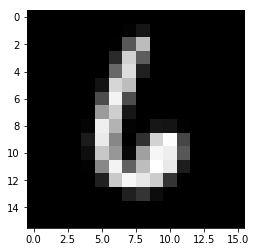

In [3]:
def extract_data(data):
    images = np.array([x[1:] for x in data])
    labels = np.array([x[0] for x in data])
    return [images, labels]

images, labels = extract_data(data)
images = preprocessing.normalize(images)

def shuffle_indices(ndata, ntest):
    idtest = np.random.choice(ndata, ntest, replace=False)
    idtrain = np.array(filter(lambda x: x not in idtest, range(ndata)))
    return [idtrain, idtest]


idtrain, idtest = shuffle_indices(7932, 932)

img_train = images[idtrain]
img_test = images[idtest]
lbl_train = labels[idtrain]
lbl_test = labels[idtest]

print (img_train.shape, img_test.shape, lbl_train.shape, lbl_test.shape)

plt.imshow(img_train[0].reshape((16, 16)), cmap='gray')
plt.show()

In [ ]:
# ndata = 7000
# e_val = []
# for C in np.logspace(-3, 8, 12) # testa todos os valores de C = 10^i, com i variando de -3 a 8
#     for k in range 5
#         lin_clf = svm.SVC(kernel='linear', C=C)
#         val_i = range(k*ndata/5, ((k+1)*ndata/5))
#         tr_i = filter(lambda x: x not in val_idx, range(ndata))
#         lin_clf.fit(img_train[tr_i], lbl_train[tr_i])
#         pred = lin_clf.predict(img_train[val_i], lbl_train[val_i])
#         e_val.append(sum(abs(pred-lbl_train[val_i]))) 


# StratifiedShuffleSplit faz o cross-validation. Para esse problema, 
# estamos separando o dataset de treino (7000 imagens) em 5 grupos. 
# Em cada rodada, um desses grupos sera removido e usado para 
# validacao do treino efetuado com os outros 4
crossval = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

# C vai assumir os valores 10^i, com i variando de -1 a 6
c_range = np.logspace(-1, 6, 8) 
# gamma vai assumir os valores 4^i, com i variando de -4 a 3
gamma_range = np.logspace(-4, 3, 8)

# GridSearchCV faz uma busca exaustiva no espaco de parametros passado, testando cada um deles
grid_lin = GridSearchCV(svm.SVC(kernel='linear', cache_size=1000), 
                        param_grid=dict(C=c_range), 
                        cv=crossval, n_jobs=-1)
grid_lin.fit(X=img_train, y=lbl_train)

print("Kernel linear --- ")
print("Melhor valor para C: %s com e_out de %0.5f" % (grid_lin.best_params_, grid_lin.best_score_))


grid_rbf = GridSearchCV(svm.SVC(kernel='rbf', cache_size=1000), 
                        param_grid=dict(C=c_range, gamma=gamma_range), 
                        cv=crossval, n_jobs=-1)
grid_rbf.fit(X=img_train, y=lbl_train)

print("Kernel RBF --- ")
print("Melhor valor para os parâmetros: %s com e_out de %0.5f" % (grid_rbf.best_params_, grid_rbf.best_score_))

